## 1. Importing Data

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

In [3]:
x = data.data
y = data.target

print(x.shape, y.shape)
print(data.feature_names)
print(data.target_names)

(569, 30) (569,)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


## 2. EDA

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


target
1    357
0    212
Name: count, dtype: int64

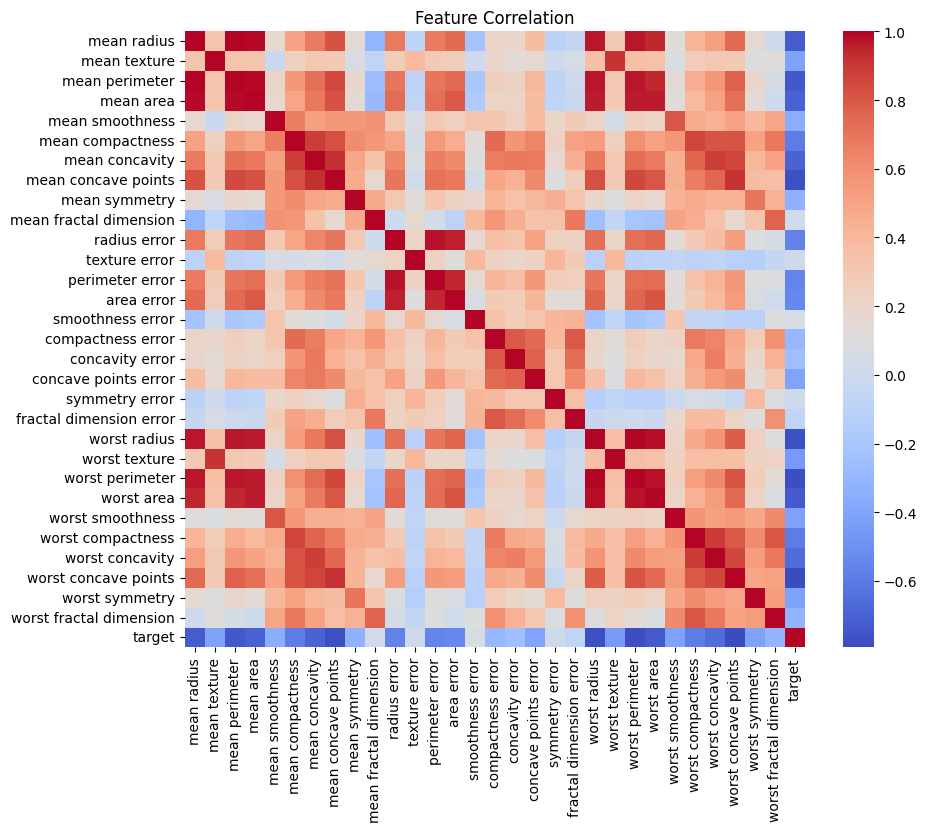

In [5]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

display(df.describe())
display(df['target'].value_counts())

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

## 3. Data Preprocessing 

### 3.1. Removing Outliers

In [6]:
def remove_outlier(df, exclude_cols = None, threshold=1.5):
    if exclude_cols is None:
        exclude_cols = []
    outlier = pd.Series([False] * len(df), index=df.index)
    for col in df.columns:
        if col in exclude_cols:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        low_fence = Q1-threshold*IQR
        up_fence = Q3+threshold*IQR
        outlier |= (df[col] < low_fence) | (df[col] > up_fence)

    return df[~outlier]

In [7]:
df_removed = remove_outlier(df, exclude_cols=['target'])
print(df.shape[0])
print(df_removed.shape[0])

569
398


### 3.2. Feature Selection

In [8]:
X = df_removed.drop(columns='target')
y = df_removed['target']

select_ftr = SelectKBest(score_func=f_classif, k=20)
ftr_selected = select_ftr.fit_transform(X, y)
features = X.columns[select_ftr.get_support()]
print('selected features:\n',features)

selected features:
 Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean compactness', 'mean concavity', 'mean concave points',
       'radius error', 'perimeter error', 'area error', 'concave points error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry'],
      dtype='object')


### 3.3. Train & Test Split + Scaling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(ftr_selected, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

In [11]:
pd.DataFrame(X_tr, columns=features)

,mean radius,mean texture,mean perimeter,mean area,mean compactness,mean concavity,mean concave points,radius error,perimeter error,area error,concave points error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry
0,-1.787363,-0.757216,-1.740905,-1.457383,-0.282057,-0.290331,-0.482677,1.757459,2.298039,0.218690,1.270123,-1.549929,-1.231632,-1.484777,-1.268656,-1.355871,-0.813359,-0.819753,-0.988888,-0.830220
1,-0.550664,-0.716491,-0.558911,-0.567665,-0.437631,-0.405894,-0.684191,-0.624755,-0.801506,-0.665366,-0.749716,-0.436746,0.039180,-0.490569,-0.485306,0.454496,-0.115306,0.066053,-0.415601,1.357843
2,-0.800222,0.108174,-0.838472,-0.775691,-1.067222,-0.761099,-0.563594,-0.329850,-0.240834,-0.581501,-0.021286,-0.832048,0.258042,-0.865550,-0.805245,-0.840766,-1.069650,-0.947780,-0.701046,1.098517
3,-0.265454,-1.192455,-0.276425,-0.353043,-0.079198,-0.986346,-0.660460,-0.980172,-0.911892,-0.840664,-0.510594,-0.488044,-1.270462,-0.457002,-0.527140,0.059416,-0.606254,-1.101518,-0.673081,-0.980722
4,-0.760609,-0.619771,-0.788759,-0.746225,-0.810949,-0.722983,-0.505629,-1.056770,-1.185124,-0.911918,-0.928743,-0.786784,-0.686242,-0.848767,-0.756635,1.224652,-0.931704,-0.794175,-0.632132,0.135306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,2.689632,0.273616,2.765995,2.980209,1.817165,3.077017,3.488861,0.953174,0.911113,1.625486,2.285950,2.085947,0.069185,2.080856,2.198824,1.894788,0.752867,2.102290,2.400492,0.554395
314,-0.190191,-0.543414,-0.232561,-0.246171,-0.962728,-0.462257,-0.484233,-0.876764,-0.744674,-0.691219,-0.399456,-0.373377,-0.472675,-0.356742,-0.388971,-0.945788,-0.574819,-0.270753,-0.295151,0.535872
315,2.820353,2.378548,2.801086,3.283671,0.605851,1.903138,1.835512,1.649455,1.740646,2.730241,0.226636,2.822236,2.241920,2.818452,3.356614,-0.315660,0.585520,1.324221,1.182009,-0.823274
316,1.077406,-0.105628,1.087459,1.058279,0.789737,0.667829,0.903024,3.035121,2.577829,2.986882,0.417732,1.449239,0.104486,1.330011,1.474100,0.139432,0.100119,0.424286,0.488872,-0.001303


In [12]:
pd.DataFrame(X_te, columns=features)

,mean radius,mean texture,mean perimeter,mean area,mean compactness,mean concavity,mean concave points,radius error,perimeter error,area error,concave points error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry
0,1.766662,-1.332445,1.643072,1.845962,-0.714336,-0.346288,0.216398,1.338465,1.080517,1.528379,-0.646624,1.419063,-1.104551,1.246093,1.406341,-1.499900,-1.044872,-0.750182,-0.273978,-2.337553
1,0.102941,-1.350262,0.080337,-0.015275,0.013620,-0.459215,-0.411875,-0.754206,-0.856152,-0.587176,-0.842246,0.067189,-1.469909,0.036348,-0.077870,0.124429,0.320167,-0.274101,-0.330907,-0.955252
2,0.162360,-0.680858,0.229475,0.051574,1.207130,0.331682,0.563018,-0.229506,-0.237555,-0.211988,-0.201822,0.438351,-0.673887,0.504080,0.234999,0.624531,1.307611,0.408886,0.822457,-0.471332
3,-0.554625,1.635331,-0.520310,-0.576461,0.161605,-0.144357,0.253744,-0.355128,-0.338104,-0.461693,1.669916,-0.644958,1.002879,-0.636322,-0.644392,0.124429,-0.282654,-0.374540,0.460907,-0.448178
4,0.027678,2.480358,-0.036050,-0.045182,-1.149533,-0.989792,-0.974402,-1.070558,-0.846316,-0.744187,-1.214381,-0.128953,1.933042,-0.078487,-0.153288,-0.890776,-0.620123,-0.920661,-0.785341,-0.228214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.709113,-1.431710,-0.711558,-0.702684,-0.332553,-0.396771,-0.105713,-0.591051,-0.764346,-0.691219,-0.785672,-0.620818,-1.326943,-0.703456,-0.648516,0.724551,-0.255841,-0.164957,-0.252405,-0.047612
76,0.879344,0.232892,0.789182,0.819027,-0.889757,-0.394135,-0.301392,-0.604073,-0.699864,-0.285764,-1.215639,0.842706,1.234096,0.751418,0.754090,-1.010801,-0.296523,0.061366,-0.228634,-0.253683
77,0.625825,-0.385607,0.568107,0.499292,-0.227475,-0.719942,0.061956,-0.286189,-0.307502,-0.153345,-0.235264,0.299543,-0.296173,0.252326,0.179908,-0.350667,-0.453700,-1.006771,-0.245214,-0.899683
78,-0.293183,-0.075085,-0.223203,-0.381630,1.364746,0.377908,0.564963,-0.584157,-0.522809,-0.524119,0.078285,-0.222498,-0.446199,-0.158872,-0.291457,1.234654,1.584982,0.946570,0.870397,1.012846


## 4. Modeling